In [9]:
print("Kernal Started")

Kernal Started


# Setup

In [ ]:
!pip install tensorflow==2.10.0

In [ ]:
!pip install numpy==1.24.1

In [ ]:
!pip install Pillow==9.3.0

In [3]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

import google.protobuf

print("Protocol Buffers version:", google.protobuf.__version__)


TensorFlow version: 2.10.0
Keras version: 2.10.0
Protocol Buffers version: 3.19.6


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [5]:
print("Done setup")

Done setup


# Ensemble

In [12]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

train_path='/kaggle/input/cinnamon-original/Cinnamon_NoAug/Data/train'
test_path='/kaggle/input/cinnamon-original/Cinnamon_NoAug/Data/test'
valid_path='/kaggle/input/cinnamon-original/Cinnamon_NoAug/Data/valid'

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=True)

valid_set = valid_datagen.flow_from_directory(valid_path,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='categorical',
                                              shuffle=True)

# Set up data
batch_size = 32
img_height = 224
img_width = 224


# Define early stopping and model checkpoint callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('ensemble_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

Found 1480 images belonging to 3 classes.
Found 420 images belonging to 3 classes.


In [13]:
from keras.layers import Input, Dense, Dropout, concatenate
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.layers import Input, Average

model_1 = load_model('/kaggle/input/base-models-cinnamon/pre-models/InceptionV3.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='Inception')
model_2 = load_model('/kaggle/input/base-models-cinnamon/pre-models/Dense121.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='DenseNet')
model_3 = load_model('/kaggle/input/base-models-cinnamon/pre-models/VGG16.h5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='VGG16')
models = [model_1, model_2, model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

# Compile the model
ensemble_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Inception (Functional)         (None, 3)            21808931    ['input_3[0][0]']                
                                                                                                  
 DenseNet (Functional)          (None, 3)            7040579     ['input_3[0][0]']                
                                                                                                  
 VGG16 (Functional)             (None, 3)            14716227    ['input_3[0][0]']         

In [ ]:
from keras.utils.vis_utils import plot_model

# Save the plot to a file
plot_model(ensemble_model, to_file='ensemble_model_plot.png', show_shapes=True, show_layer_names=True)


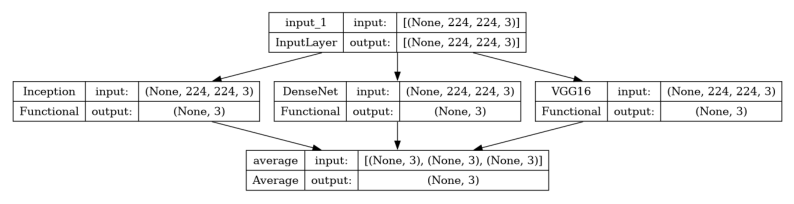

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('ensemble_model_plot.png')

# Set the size of the plot
plt.figure(figsize=(10, 10))  # Adjust the values to change the size

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()


In [14]:
# Train the model
history = ensemble_model.fit(training_set, 
                              validation_data=valid_set,
                              epochs=10,
                              callbacks=[early_stop])


# ensemble_model.save('path')

Epoch 1/10
47/47 [==============================] - 540s 11s/step - loss: 0.0457 - accuracy: 1.0000 - val_loss: 0.0461 - val_accuracy: 1.0000
Epoch 2/10
47/47 [==============================] - 544s 12s/step - loss: 0.0376 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 1.0000
Epoch 3/10
47/47 [==============================] - 524s 11s/step - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.0351 - val_accuracy: 1.0000
Epoch 4/10
47/47 [==============================] - 523s 11s/step - loss: 0.0292 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 1.0000
Epoch 5/10
47/47 [==============================] - 526s 11s/step - loss: 0.0269 - accuracy: 1.0000 - val_loss: 0.0294 - val_accuracy: 1.0000
Epoch 6/10
47/47 [==============================] - 514s 11s/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 7/10
47/47 [==============================] - 522s 11s/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 1.0000
Epoch 

In [36]:
# Save the entire model
ensemble_model.save('ensemble_kaggle1.h5')

# Download the saved model
from IPython.display import FileLink
FileLink(r'model_kaggle1.h5')

ValueError: Unable to synchronously create dataset (name already exists)

In [38]:
# Save the model in TensorFlow SavedModel format
ensemble_model.save('/kaggle/working/new2/model-final-ens2', save_format='tf')

In [21]:
print(ensemble_model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [22]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
test_batches = test_datagen.flow_from_directory(test_path,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

Found 205 images belonging to 3 classes.


In [24]:
score = ensemble_model.evaluate(test_batches)
print(score)

7/7 [==============================] - 60s 8s/step - loss: 0.0194 - accuracy: 1.0000
[0.01941482536494732, 1.0]


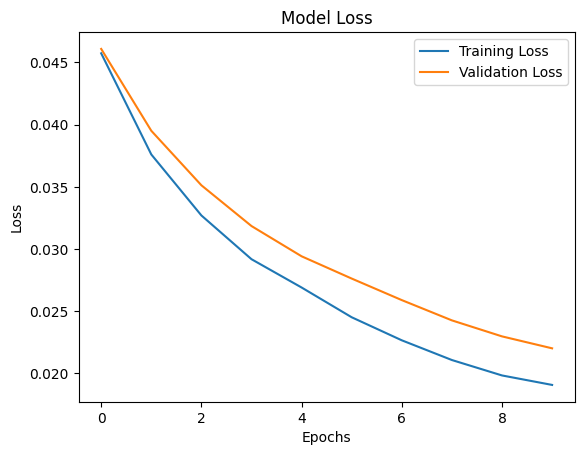

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()


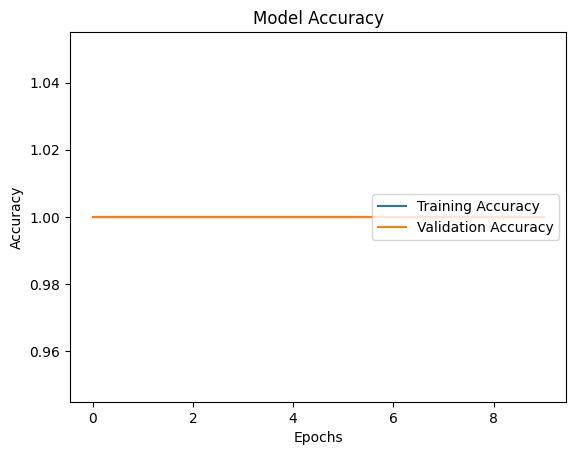

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='center right')
plt.show()


In [27]:
predictions= ensemble_model.predict(test_batches)

7/7 [==============================] - 62s 8s/step


In [28]:
rounded_prediction = np.argmax(predictions,axis=-1)

In [29]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max()/2.

    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [30]:
cm = confusion_matrix(y_true=test_batches.classes,y_pred=rounded_prediction)

In [31]:
cm_plot_labels=["mite","normal","yellow"]

Confusion matrix, without normalization
[[70  0  0]
 [ 0 70  0]
 [ 0  0 65]]


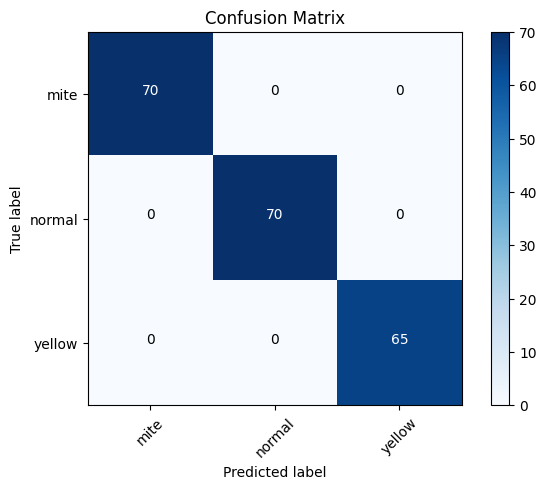

In [32]:
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')

In [33]:
from sklearn.metrics import classification_report

print(classification_report(test_batches.classes,rounded_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        70
           2       1.00      1.00      1.00        65

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205

